In [63]:
from google.colab import files
from IPython.display import Image

uploaded = files.upload()

Saving Screenshot_27.png to Screenshot_27.png


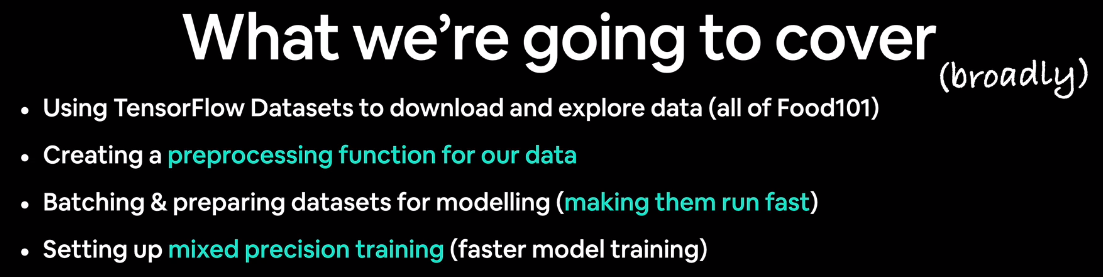

In [64]:
Image('Screenshot_27.png', width=1000)

# **Get helper functions**

In [31]:
# Hide warning logs (see: https://stackoverflow.com/a/38645250/7900723)
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Check TensorFlow version (should be 2.4.0+)
import tensorflow as tf
print(tf.__version__)

2.8.2


In [32]:
# Get helper functions file
if not os.path.exists("helper_functions.py"):
    print("Downloading helper functions...")
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("Helper functions file already exists, skipping download...")

Helper functions file already exists, skipping download...


In [33]:
# Import series of helper functions for the notebook 
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

# **Use TensorFlow Datasets**

In [34]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [35]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

In [36]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [37]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

# **Exploring TensorFlow Datasets**

In [38]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [39]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [40]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 38
  Class name (str form): fish_and_chips
        


In [41]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[182, 225, 242],
        [180, 223, 240],
        [179, 220, 238],
        ...,
        [157, 202, 221],
        [157, 204, 222],
        [158, 205, 223]],

       [[179, 222, 239],
        [178, 221, 238],
        [178, 219, 237],
        ...,
        [162, 207, 226],
        [162, 209, 227],
        [163, 210, 228]],

       [[178, 221, 238],
        [176, 219, 236],
        [177, 218, 236],
        ...,
        [168, 213, 232],
        [168, 215, 233],
        [167, 214, 232]],

       ...,

       [[149,  97,  39],
        [159, 109,  50],
        [156, 110,  50],
        ...,
        [108, 143, 149],
        [108, 143, 149],
        [107, 142, 148]],

       [[168, 117,  60],
        [172, 123,  65],
        [170, 125,  66],
        ...,
        [106, 141, 147],
        [106, 141, 147],
        [105, 140, 146]],

       [[183, 132,  75],
        [182, 133,  75],
        [179, 134,  75],
        ...,
        [106, 141, 14

In [42]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

# **Plot an image** 

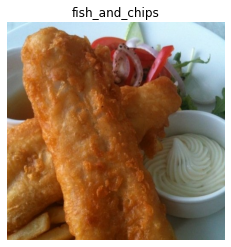

In [43]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

# **Create preprocessing functions**
models like data to be:

*   In float32 data type (our data is currently in uint8 data type)
*   Have all of the same size tensors (batches require all tensors have the  same shape, e.g. (224, 224, 3)) (but our data are in differnet sized tensors)
* Scaled (values between 0 & 1), also called normalized (our data is currently in not scaled (the pixel values are between 0 & 255)
)

In [44]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [45]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[182 225 242]
  [180 223 240]
  [179 220 238]
  ...
  [157 202 221]
  [157 204 222]
  [158 205 223]]

 [[179 222 239]
  [178 221 238]
  [178 219 237]
  ...
  [162 207 226]
  [162 209 227]
  [163 210 228]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[179.19897 222.19897 239.19897]
  [178.02551 219.02551 237.02551]
  [184.21428 220.78572 240.     ]
  ...
  [164.71938 206.28062 226.     ]
  [159.61736 204.61736 223.61736]
  [160.57146 207.57146 225.57146]]

 [[177.31123 220.31123 237.31123]
  [177.86224 218.86224 236.86224]
  [184.0153  221.0153  240.0153 ]
  ...
  [163.12755 203.53067 223.72963]
  [169.72447 213.00002 232.00002]
  [168.5714  214.37758 232.97449]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


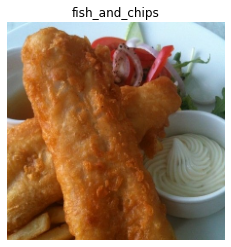

In [46]:
# We can still plot our preprocessed image as long as we 
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

# **Batch & prepare datasets**

In [47]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [48]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

# **Setup mixed precision training**
Normally, tensors in TensorFlow default to the float32 datatype. Our GPU has a limited memory, mixed precision training involves using a mix of float16 and float32 tensors to make better use of your GPU's memory. Using mixed precision training, your model will make use of float32 and float16 data types to use less memory where possible and in turn run faster





In [50]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision 

In [51]:
mixed_precision.global_policy() # should output "mixed_float16"

<Policy "mixed_float16">

# **Create modelling callbacks**


In [49]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=1) # don't print out whether or not model is being saved 

# **Build feature extraction model**
This ensures the outputs of our model are **returned back** to the **float32** data type which is more numerically stable than the float16 datatype. So, our model needs a separate output layer with a hard-coded dtype=float32

In [52]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer", dtype=tf.float16)
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [53]:
# Check out our model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [56]:
# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20220714-142557
Epoch 1/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.8217 - accuracy: 0.5564
Epoch 1: val_loss improved from inf to 1.22420, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 198s 77ms/step - loss: 1.8217 - accuracy: 0.5564 - val_loss: 1.2242 - val_accuracy: 0.6843
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.2925 - accuracy: 0.6675
Epoch 2: val_loss improved from 1.22420 to 1.12675, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 174s 73ms/step - loss: 1.2924 - accuracy: 0.6675 - val_loss: 1.1268 - val_accuracy: 0.6939
Epoch 3/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.1420 - accuracy: 0.7040
Epoch 3: val_loss improved from 1.12675 to 1.09127, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] -

In [57]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 52s 66ms/step - loss: 1.0912 - accuracy: 0.7064


[1.0911891460418701, 0.7063762545585632]

In [54]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float16 <Policy "float16">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [62]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 False float32 <Policy "float32">
rescaling_1 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False